# DataKit Challenge 2: Seasonality

### Introduction

This notebook tackles Challenge 2 of the DataKit Challenge – Producers Direct. The guiding questions are:

- How do question types (e.g., planting, pests, harvesting, markets) fluctuate by month or season?
- Do these patterns change over time or by region?
- Can we map the farming calendar (planting, growing, harvesting) based on question data?

Due to language and time constraints, the analysis focuses primarily on **Kenya** (English questions), with **Uganda** included as a comparative region for selected crops in Guiding Question 2.

## 1. Data Loading & Engineering

In [ ]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# 1. CONFIGURATION
# ----------------
PROJECT_ROOT = Path("..").resolve()

# Directories
VIZ_DIR = PROJECT_ROOT / "visualizations"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw" / "producers_direct_raw_data.csv"
PARQUET_PATH = PROCESSED_DIR / "wefarm_data_english_v2.parquet"

VIZ_DIR.mkdir(exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Visualization dir:", VIZ_DIR)
print("Parquet path     :", PARQUET_PATH)

# 2. DATA PIPELINE (DuckDB)
# -------------------------
print("Initializing Data Pipeline...")
con = duckdb.connect()

def ensure_english_parquet():
    """
    Create the English-only parquet (if it does not yet exist)from the big raw CSV.
    """
    if not PARQUET_PATH.exists():
        print("Parquet not found, creating it...")
        con.execute(f"""
            COPY (
                SELECT
                    question_id,
                    CAST(question_sent AS TIMESTAMPTZ) AS q_date,
                    question_body AS q_text,
                    question_topic,
                    question_user_status,
                    CASE
                        WHEN LOWER(question_user_country_code) = 'ke' THEN 'KEN'
                        WHEN LOWER(question_user_country_code) = 'ug' THEN 'UGA'
                        WHEN LOWER(question_user_country_code) = 'tz' THEN 'TZA'
                        ELSE question_user_country_code
                    END AS country_std
                FROM read_csv_auto('{RAW_DATA_PATH}', sample_size=-1)
                WHERE LOWER(question_language) IN ('eng', 'en')
            ) TO '{PARQUET_PATH}' (FORMAT PARQUET);
        """)
        print("Conversion complete.")
    else:
        print(f"Using existing parquet at {PARQUET_PATH}")

def base_seasonality_query(country="KEN"):
    """
    Base aggregation for seasonality: topic × month for one country. Uses q_date from the parquet.
    """
    return f"""
    WITH base AS (
        SELECT
            q_date,
            COALESCE(question_topic, 'Unknown') AS question_topic,
            country_std,
            EXTRACT(year  FROM q_date) AS year,
            EXTRACT(month FROM q_date) AS month_num,
            CASE
                WHEN month_num IN (1, 2)          THEN 'Short Dry'
                WHEN month_num BETWEEN 3 AND 5    THEN 'Long Rains'
                WHEN month_num BETWEEN 6 AND 9    THEN 'Long Dry'
                WHEN month_num BETWEEN 10 AND 12  THEN 'Short Rains'
            END AS season
        FROM read_parquet('{PARQUET_PATH}')
        WHERE country_std = '{country}'
    )
    SELECT
        question_topic,
        month_num,
        season,
        COUNT(*) AS n_questions
    FROM base
    GROUP BY 1, 2, 3
    ORDER BY question_topic, month_num
    """

## 2. Guiding Question 1: How do question types (e.g. planting, pests, harvesting, markets) fluctuate by month or season?


In [31]:
MONTH_LABELS = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]

def plot_topic_month_heatmap(con, country="KEN",
                             min_total_questions=5000,
                             save=True):
    # 1. Pull data
    query = base_seasonality_query(country)
    df = con.execute(query).df()

    # 2. Pivot to topic × month
    pt = (df.pivot_table(index="question_topic",
                         columns="month_num",
                         values="n_questions",
                         aggfunc="sum",
                         fill_value=0))

    # 3. Filter out very rare topics
    topic_totals = pt.sum(axis=1)
    pt = pt[topic_totals >= min_total_questions]

    # Ensure columns are ordered Jan–Dec
    pt = pt.reindex(columns=sorted(pt.columns))

    # 4. Plot
    height = max(6.0, 0.35 * len(pt))   # height is now a float
    plt.figure(figsize=(12.0, height))
    sns.heatmap(pt, linewidths=0.3)
    plt.title(f"Question volume by topic and month — {country}")
    plt.xlabel("Month")
    plt.ylabel("Topic")

    # Replace month ticks with names
    ticks = [i + 0.5 for i in range(len(pt.columns))]
    labels = [MONTH_LABELS[m-1] for m in pt.columns]
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")

    plt.tight_layout()

    if save:
        out_path = VIZ_DIR / f"01_topic_heatmap_{country}.png"
        plt.savefig(out_path, dpi=300)
        print(f"Saved heatmap to {out_path}")

    plt.show()
    return pt

In [ ]:
topic_month_pt_kenya = plot_topic_month_heatmap(con, country="KEN",
                                                min_total_questions=5000)

In [4]:
# Share of Unknown vs all topics
total_by_topic = topic_month_pt_kenya.sum(axis=1)
total_all = total_by_topic.sum()
unknown_total = total_by_topic.get("Unknown", 0)

unknown_share = unknown_total / total_all
print(f"Unknown share of questions (Kenya): {unknown_share:.1%}")

Unknown share of questions (Kenya): 11.1%


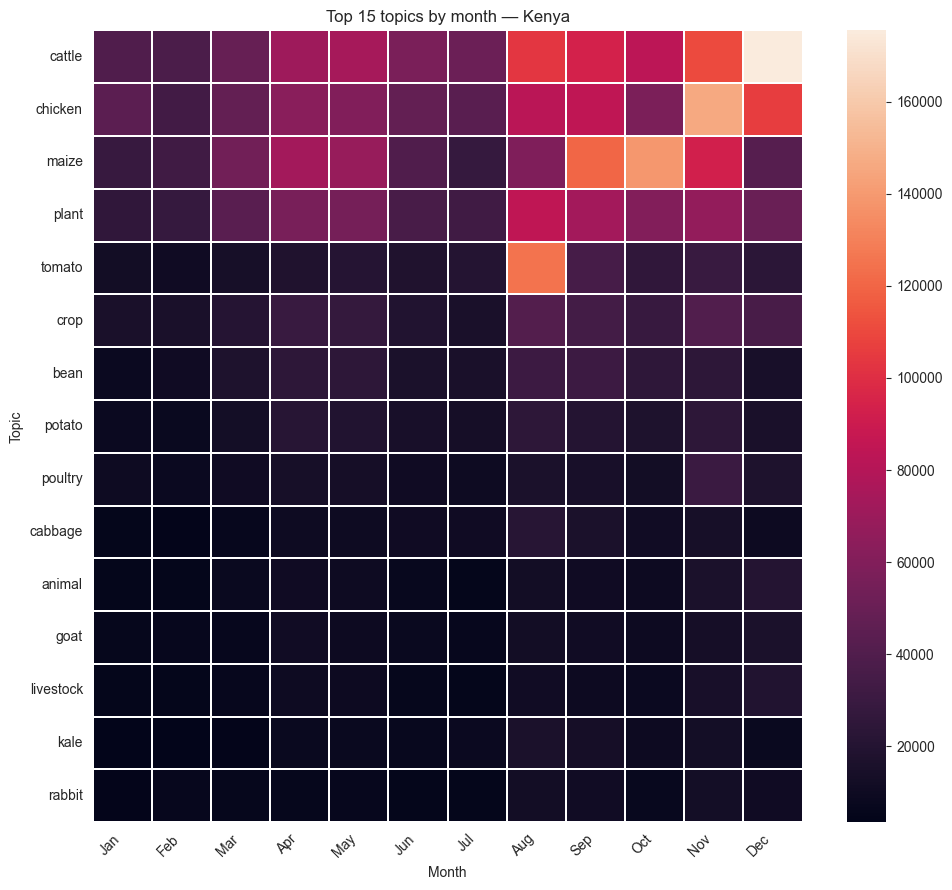

In [5]:
# Drop 'Unknown' for the focused view
pt_known = topic_month_pt_kenya.drop(index="Unknown", errors="ignore")

# Get top 15 topics by total questions
top_topics = (
    pt_known
    .sum(axis=1)                # total over months
    .sort_values(ascending=False)
    .head(15)
    .index
)

pt_top = pt_known.loc[top_topics]

plt.figure(figsize=(10, 0.6 * len(pt_top)))
sns.heatmap(pt_top, linewidths=0.3)
plt.title("Top 15 topics by month — Kenya")
plt.xlabel("Month")
plt.ylabel("Topic")

ticks = [i + 0.5 for i in range(len(pt_top.columns))]
labels = [MONTH_LABELS[m-1] for m in pt_top.columns]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")

plt.tight_layout()
plt.savefig(VIZ_DIR / "01_topic_heatmap_KEN_top15.png", dpi=300)
plt.show()

In [6]:
def summarise_topic_peaks(pt, top_k=2):
    # pt: pivot table from the heatmap
    long = (
        pt
        .stack()
        .reset_index()
        .rename(columns={0: "n_questions",
                         "level_0": "topic",
                         "level_1": "month_num"})
    )

    # Sort by topic then volume
    long = long.sort_values(["question_topic", "n_questions"],
                            ascending=[True, False])

    # Take top_k months per topic
    top = (
        long.groupby("question_topic")
            .head(top_k)
            .copy()
    )

    month_map = {i+1: name for i, name in enumerate(MONTH_LABELS)}
    top["month_name"] = top["month_num"].map(month_map)

    return top[["question_topic", "month_name", "n_questions"]]

peak_months_kenya = summarise_topic_peaks(topic_month_pt_kenya, top_k=2)
peak_months_kenya.head()

,question_topic,month_name,n_questions
7,Unknown,Aug,92424
11,Unknown,Dec,90042
23,animal,Dec,19812
22,animal,Nov,15798
31,avocado,Aug,3266


In [7]:
interesting = ["maize", "tomato", "livestock", "coffee", "animal"]

peak_months_kenya.query("question_topic in @interesting").sort_values(
    ["question_topic", "n_questions"], ascending=[True, False]
)

,question_topic,month_name,n_questions
23,animal,Dec,19812
22,animal,Nov,15798
190,coffee,Nov,4660
187,coffee,Aug,4125
335,livestock,Dec,18538
334,livestock,Nov,14913
345,maize,Oct,138957
344,maize,Sep,120241
739,tomato,Aug,124911
740,tomato,Sep,35352


In [8]:
df_season_q1 = con.execute(base_seasonality_query("KEN")).df()

interesting_q1 = ["cattle", "chicken", "animal"]

season_share_q1 = (
    df_season_q1
    .query("question_topic in @interesting_q1")
    .groupby(["question_topic", "season"], as_index=False)["n_questions"]
    .sum()
)

season_share_q1["share"] = (
    season_share_q1
    .groupby("question_topic")["n_questions"]
    .transform(lambda x: x / x.sum())
)

In [33]:
season_share_q1.sort_values(
    ["question_topic", "share"],
    ascending=[True, False]
)

,question_topic,season,n_questions,share
3,animal,Short Rains,44978,0.382352
0,animal,Long Dry,34589,0.294037
1,animal,Long Rains,27796,0.236290
2,animal,Short Dry,10272,0.087321
7,cattle,Short Rains,369261,0.390435
4,cattle,Long Dry,304705,0.322178
5,cattle,Long Rains,194307,0.205449
6,cattle,Short Dry,77494,0.081938
11,chicken,Short Rains,310030,0.380250
8,chicken,Long Dry,257407,0.315709


### Insights: How do question types fluctuate by month / season in Kenya?

In the Kenyan English subset, around **89 %** of questions have a specific topic label, while **11 %** are tagged as “Unknown”. I treat “Unknown” as a residual bucket and focus the detailed seasonality analysis on the best-labelled topics (top 15 by question volume).

The heatmap of the top 15 topics shows that most activity is concentrated in the **second half of the year**. Across key topics such as **cattle, chicken, maize, plant and tomato**, question volumes are low in January–July and then rise sharply from **August onwards**, with clear peaks in **October–December**. A smaller bump around **March–May** (the long rains) is visible for "maize" and general “plant” questions.

Looking at seasons rather than individual months confirms this pattern. For example:

- For **cattle**, about **39 %** of questions occur during the *short rains* (Oct–Dec), **32 %** during the *long dry* (Jun–Sep) and **21 %** during the *long rains* (Mar–May), with less than 10 % in the short dry season (Jan–Feb).
- For **chicken**, a similar picture emerges: roughly **38 %** of questions are asked in the *short rains* and around **32 %** in the *long dry* period.
- For more general **animal** questions, around **38 %** fall in the short rains, **29 %** in the long dry and **24 %** in the long rains.

Taken together, this suggests that in Kenya farmers most often seek advice on major crops and livestock **towards the end of the year and during the rainy seasons**, with a secondary peak during the long rains when planting and early growth decisions are made.

In [9]:
calendar_query = f"""
    WITH classified_questions AS (
        SELECT
            EXTRACT(month FROM q_date) AS month_num,
            COALESCE(question_topic, 'Unknown') AS crop,
            q_text,
            CASE
                WHEN REGEXP_MATCHES(LOWER(q_text),
                     '(seed|plant|sow|prepare|land|variety|spacing|panda|mbegu)')
                    THEN '1. Planting'
                WHEN REGEXP_MATCHES(LOWER(q_text),
                     '(pest|disease|yellow|wilt|spot|insect|worm|spray|wadudu)')
                    THEN '2. Maintenance'
                WHEN REGEXP_MATCHES(LOWER(q_text),
                     '(harvest|ripe|mature|store|dry|picking|sell|price|market|soko)')
                    THEN '3. Harvest/Market'
                ELSE 'Other'
            END AS stage
        FROM read_parquet('{PARQUET_PATH}')
        WHERE country_std = 'KEN'
          AND LOWER(question_topic) IN ('maize', 'tomato')
    )
    SELECT
        crop,
        month_num,
        stage,
        COUNT(*) AS count
    FROM classified_questions
    WHERE stage != 'Other'
    GROUP BY 1, 2, 3
    ORDER BY crop, stage, month_num
"""

df_calendar = con.execute(calendar_query).df()
df_calendar.head()

,crop,month_num,stage,count
0,maize,1,1. Planting,15777
1,maize,2,1. Planting,18956
2,maize,3,1. Planting,30738
3,maize,4,1. Planting,34119
4,maize,5,1. Planting,25446


In [ ]:
month_map = {i+1: name for i, name in enumerate(MONTH_LABELS)}
df_calendar["month_name"] = df_calendar["month_num"].map(month_map)

g = sns.FacetGrid(
    df_calendar,
    col="crop",
    hue="stage",
    height=5,
    aspect=1.5,
    sharey=False
)
g.map(sns.lineplot, "month_num", "count", marker="o")
g.set_xticklabels(rotation=45)
g.set_xlabels("Month")
g.set_ylabels("Number of questions")
g.add_legend(title="Stage")
g.fig.suptitle("Farming lifecycle by crop — Kenya (Maize & Tomato)", y=1.05)

save_path = VIZ_DIR / "02_crop_calendar.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved chart to: {save_path}")

#### Reconstructing a farming calendar for "maize" and "tomato" (Kenya)

To link question patterns more directly to the farming lifecycle, each "maize" and "tomato" question in Kenya was classified into three broad “intent” categories using simple keyword rules:

- **1. Planting:** mentions of seed, planting, sowing, land preparation, varieties or spacing (incl. Swahili terms such as *panda*, *mbegu*).
- **2. Maintenance:** mentions of pests, diseases, yellowing, wilting, insects, worms or spraying (*wadudu*).
- **3. Harvest / Market:** mentions of harvesting, ripeness, maturity, storage, drying, picking, selling, prices or markets (*soko*).

Aggregating these intents by month result in a crop calendar:

- For **maize**, planting questions gradually increase from January and are elevated during **March–April**, then peak strongly in **October**. Maintenance and harvest/market questions remain relatively low in the first half of the year, but rise from **June onwards** and also reach their highest levels in **October**. This suggests two main activity windows for maize: an early planting phase during the long rains (Mar–Apr) and a broader planting/management/harvest phase centred on the short rains (around Oct).
- For **tomato**, planting, maintenance and harvest/market questions all peak sharply in **August**, with lower activity before and after. Tomato therefore appears to have a more compressed seasonal window than maize, with most farmer interactions concentrated around a single main production cycle.

For maize in Kenya, planting-related questions (keywords such as “seed”, “spacing”, “panda/mbegu”) peak in March–April, aligning with the start of the long rains. Maintenance questions about pests and diseases are most frequent during June–August, when crops are in the field. Harvest and market questions (e.g. “harvest”, “price”, “soko”) peak in October–December, during the short rains, suggesting that farmers seek price and marketing advice mainly around the harvest period. Tomato shows a similar but slightly shifted pattern, with maintenance and harvest questions concentrated later in the year.

In [32]:
calendar_peaks = (
    df_calendar
    .groupby(["crop", "stage", "month_num"], as_index=False)
    .agg(count=("count", "sum"))
    .sort_values(["crop", "stage", "count"], ascending=[True, True, False])
    .groupby(["crop", "stage"], as_index=False)
    .head(1)
)

calendar_peaks["month_name"] = calendar_peaks["month_num"].map(month_map)
calendar_peaks

,crop,stage,month_num,count,month_name
9,maize,1. Planting,10,53781,Oct
21,maize,2. Maintenance,10,15798,Oct
33,maize,3. Harvest/Market,10,13246,Oct
43,tomato,1. Planting,8,43108,Aug
55,tomato,2. Maintenance,8,16166,Aug
67,tomato,3. Harvest/Market,8,8801,Aug


## 3. Guiding Question 2: Do these patterns change over time or by region?

In [12]:
def base_seasonality_query_multi(countries=("KEN", "UGA")):
    countries_list = ",".join(f"'{c}'" for c in countries)
    return f"""
    WITH base AS (
        SELECT
            q_date,
            COALESCE(question_topic, 'Unknown') AS question_topic,
            country_std,
            EXTRACT(month FROM q_date) AS month_num,
            CASE
                WHEN month_num IN (1, 2)          THEN 'Short Dry'
                WHEN month_num BETWEEN 3 AND 5    THEN 'Long Rains'
                WHEN month_num BETWEEN 6 AND 9    THEN 'Long Dry'
                WHEN month_num BETWEEN 10 AND 12  THEN 'Short Rains'
            END AS season
        FROM read_parquet('{PARQUET_PATH}')
        WHERE country_std IN ({countries_list})
    )
    SELECT
        country_std,
        question_topic,
        month_num,
        season,
        COUNT(*) AS n_questions
    FROM base
    GROUP BY 1, 2, 3, 4
    """

In [13]:
df_multi = con.execute(base_seasonality_query_multi(("KEN", "UGA"))).df()
df_multi.head()

,country_std,question_topic,month_num,season,n_questions
0,KEN,onion,11,Short Rains,9754
1,KEN,chicken,11,Short Rains,146265
2,UGA,pigeon,11,Short Rains,523
3,KEN,passion-fruit,11,Short Rains,1557
4,KEN,tomato,11,Short Rains,29163


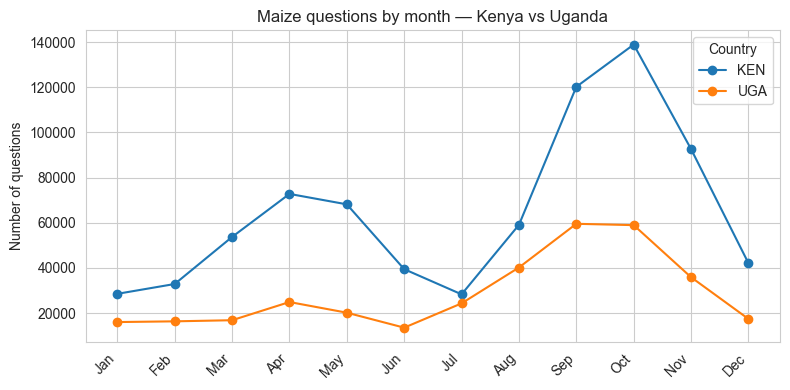

In [14]:
def plot_monthly_trend_by_country(df, topic, countries=("KEN", "UGA")):
    tmp = (
        df
        .query("question_topic == @topic and country_std in @countries")
        .groupby(["country_std", "month_num"], as_index=False)["n_questions"]
        .sum()
        .sort_values(["country_std", "month_num"])
    )

    plt.figure(figsize=(8, 4))
    for c in countries:
        sub = tmp[tmp["country_std"] == c]
        plt.plot(
            sub["month_num"],
            sub["n_questions"],
            marker="o",
            label=c
        )

    plt.xticks(
        ticks=range(1, 13),
        labels=MONTH_LABELS,
        rotation=45,
        ha="right"
    )
    plt.ylabel("Number of questions")
    plt.title(f"{topic.capitalize()} questions by month — Kenya vs Uganda")
    plt.legend(title="Country")
    plt.tight_layout()

    plt.savefig(VIZ_DIR / f"02_{topic}_kenya_vs_uganda.png", dpi=300)
    plt.show()


plot_monthly_trend_by_country(df_multi, topic="maize")

In [15]:
interesting = ["maize", "cattle", "chicken"]

season_share_regions = (
    df_multi
    .query("question_topic in @interesting")
    .groupby(["country_std", "question_topic", "season"], as_index=False)["n_questions"]
    .sum()
)

season_share_regions["share"] = (
    season_share_regions
    .groupby(["country_std", "question_topic"])["n_questions"]
    .transform(lambda x: x / x.sum())
)

season_share_regions = season_share_regions.sort_values(
    ["question_topic", "country_std", "share"],
    ascending=[True, True, False]
)

season_share_regions.head(12)

,country_std,question_topic,season,n_questions,share
3,KEN,cattle,Short Rains,369261,0.390435
0,KEN,cattle,Long Dry,304705,0.322178
1,KEN,cattle,Long Rains,194307,0.205449
2,KEN,cattle,Short Dry,77494,0.081938
12,UGA,cattle,Long Dry,73178,0.353447
15,UGA,cattle,Short Rains,60397,0.291715
13,UGA,cattle,Long Rains,50363,0.243251
14,UGA,cattle,Short Dry,23103,0.111587
7,KEN,chicken,Short Rains,310030,0.380250
4,KEN,chicken,Long Dry,257407,0.315709


In [16]:
season_share_regions.query("question_topic == 'maize'")

,country_std,question_topic,season,n_questions,share
11,KEN,maize,Short Rains,273686,0.352347
8,KEN,maize,Long Dry,247037,0.318038
9,KEN,maize,Long Rains,194653,0.250599
10,KEN,maize,Short Dry,61376,0.079016
20,UGA,maize,Long Dry,137515,0.399895
23,UGA,maize,Short Rains,112202,0.326284
21,UGA,maize,Long Rains,61841,0.179834
22,UGA,maize,Short Dry,32320,0.093987


### Regional comparison: Kenya vs Uganda

To compare regions, I focus on high-volume topics that appear in both countries, in particular "maize" and "cattle".

The monthly "maize" trend shows a very similar seasonal shape in Kenya and Uganda:

- In both countries, "maize" questions are relatively low in **Jan–Feb**, rise around **Mar–Apr** (long rains), dip in **Jun–Jul**, and then increase again to a clear peak in **Sep–Oct**.
- Kenya consistently has **higher volumes**, roughly two to three times as many maize questions per month as Uganda, but the **timing of peaks is aligned** between the two countries.

Season shares underline this:

- For **maize in Kenya**, about **35 %** of questions fall in the *short rains* (Oct–Dec), **32 %** in the *long dry* (Jun–Sep), **25 %** in the *long rains* (Mar–May) and only ~8 % in the *short dry* (Jan–Feb).
- For **maize in Uganda**, the pattern is similar but slightly shifted: around **40 %** of questions are in the *long dry* and **33 %** in the *short rains*, with fewer in the long rains and short dry.

For ""cattle", Kenya again shows a strong concentration towards the end of the year:

- In **Kenya**, roughly **39 %** of cattle questions occur in the *short rains* and **32 %** in the *long dry*, compared with only ~8 % in the *short dry*.
- In **Uganda**, cattle questions are more evenly spread: around **35 %** in the *long dry*, **29 %** in the *short rains* and **24 %** in the *long rains*.

Overall, the seasonal pattern is broadly consistent across regions, most questions come during the long dry and short rains – but Kenya shows a stronger concentration in the end-of-year rains, while Uganda’s distribution is slightly more balanced. The main difference between countries is therefore intensity rather than timing of demand.

In [17]:
def yearly_volume_by_season(country="KEN"):
    query = f"""
    WITH base AS (
        SELECT
            q_date,
            EXTRACT(year  FROM q_date)  AS year,
            EXTRACT(month FROM q_date)  AS month_num,
            CASE
                WHEN month_num IN (1, 2)          THEN 'Short Dry'
                WHEN month_num BETWEEN 3 AND 5    THEN 'Long Rains'
                WHEN month_num BETWEEN 6 AND 9    THEN 'Long Dry'
                WHEN month_num BETWEEN 10 AND 12  THEN 'Short Rains'
            END AS season
        FROM read_parquet('{PARQUET_PATH}')
        WHERE country_std = '{country}'
    )
    SELECT
        year,
        season,
        COUNT(*) AS n_questions
    FROM base
    GROUP BY 1, 2
    ORDER BY 1, 2;
    """
    return con.execute(query).df()

df_year_season_ken = yearly_volume_by_season("KEN")
df_year_season_ken

,year,season,n_questions
0,2017,Short Rains,48118
1,2018,Long Dry,1296474
2,2018,Long Rains,301028
3,2018,Short Dry,80948
4,2018,Short Rains,1917764
5,2019,Long Dry,724472
6,2019,Long Rains,734042
7,2019,Short Dry,370661
8,2019,Short Rains,267540
9,2020,Long Dry,456355


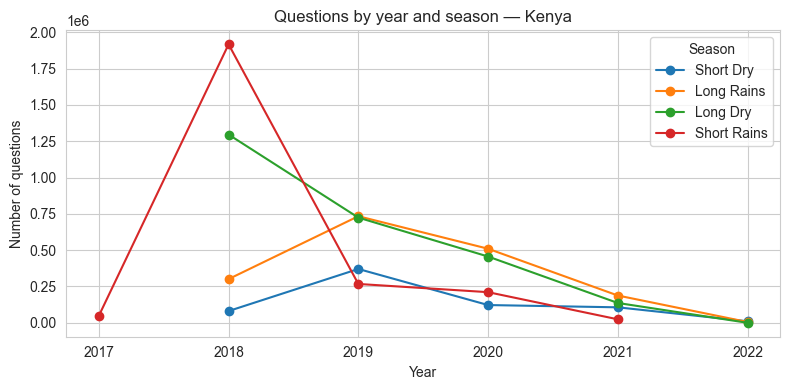

In [18]:
plt.figure(figsize=(8, 4))

for season in ["Short Dry", "Long Rains", "Long Dry", "Short Rains"]:
    sub = df_year_season_ken[df_year_season_ken["season"] == season]
    plt.plot(
        sub["year"],
        sub["n_questions"],
        marker="o",
        label=season
    )

plt.xlabel("Year")
plt.ylabel("Number of questions")
plt.title("Questions by year and season — Kenya")
plt.legend(title="Season")
plt.tight_layout()
plt.savefig(VIZ_DIR / "02_year_season_trend_KEN.png", dpi=300)
plt.show()

### Changes over time in Kenya

Aggregating question volumes by "year" and "season" for Kenya shows a time trend:

- Volumes grow sharply and peak around **2018**, with particularly high activity in the **long dry** and **short rains**.
- From **2019 onwards**, question volumes decline in all seasons, with a marked drop in **2021** and almost no traffic left in **2022**, which matches WeFarm’s shutdown described in the project brief.
- Across all years with substantial data, the **long dry (Jun–Sep)** and **short rains (Oct–Dec)** remain the busiest seasons, while the **short dry (Jan–Feb)** is consistently the quietest.

This suggests that while the overall level of usage changed dramatically over time, the underlying seasonality of demand, more questions during the main growing and harvest periods, stayed fairly stable.

## 4. Guiding Question 3: Is there an association between question data and farming season?

In [19]:
def total_by_season(country="KEN"):
    query = f"""
    WITH base AS (
        SELECT
            q_date,
            EXTRACT(month FROM q_date) AS month_num,
            CASE
                WHEN month_num IN (1, 2)          THEN 'Short Dry'
                WHEN month_num BETWEEN 3 AND 5    THEN 'Long Rains'
                WHEN month_num BETWEEN 6 AND 9    THEN 'Long Dry'
                WHEN month_num BETWEEN 10 AND 12  THEN 'Short Rains'
            END AS season
        FROM read_parquet('{PARQUET_PATH}')
        WHERE country_std = '{country}'
    )
    SELECT
        season,
        COUNT(*) AS n_questions
    FROM base
    GROUP BY 1
    ORDER BY 2 DESC;
    """
    return con.execute(query).df()

df_season_total_ken = total_by_season("KEN")
df_season_total_ken

,season,n_questions
0,Long Dry,2613792
1,Short Rains,2468376
2,Long Rains,1738355
3,Short Dry,690950


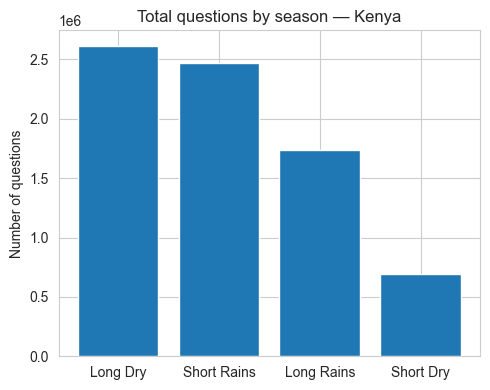

In [20]:
plt.figure(figsize=(5, 4))
plt.bar(df_season_total_ken["season"], df_season_total_ken["n_questions"])
plt.ylabel("Number of questions")
plt.title("Total questions by season — Kenya")
plt.tight_layout()
plt.savefig(VIZ_DIR / "03_total_by_season_KEN.png", dpi=300)
plt.show()

In [28]:
from scipy.stats import chi2_contingency

# Contingency table for a few key topics in Kenya
df_season_ken = con.execute(base_seasonality_query("KEN")).df()

interesting = ["maize", "cattle", "chicken", "tomato"]

contingency = (
    df_season_ken
    .query("question_topic in @interesting")
    .pivot_table(index="season",
                 columns="question_topic",
                 values="n_questions",
                 aggfunc="sum",
                 fill_value=0)
)

chi2, p, dof, expected = chi2_contingency(contingency)
chi2, p

(np.float64(90314.9497771614), np.float64(0.0))

In [25]:
# Aggregate to topic × season
season_share = (
    df_season_ken
    .query("question_topic in @interesting")
    .groupby(["question_topic", "season"], as_index=False)["n_questions"]
    .sum()
)

# Turn counts into shares within each topic
season_share["share"] = (
    season_share
    .groupby("question_topic")["n_questions"]
    .transform(lambda x: x / x.sum())
)

# Sort for readability
season_share = season_share.sort_values(
    ["question_topic", "share"],
    ascending=[True, False]
)

season_share.head(12)

,question_topic,season,n_questions,share
3,cattle,Short Rains,369261,0.390435
0,cattle,Long Dry,304705,0.322178
1,cattle,Long Rains,194307,0.205449
2,cattle,Short Dry,77494,0.081938
7,chicken,Short Rains,310030,0.380250
4,chicken,Long Dry,257407,0.315709
5,chicken,Long Rains,170054,0.208571
6,chicken,Short Dry,77840,0.095470
11,maize,Short Rains,273686,0.352347
8,maize,Long Dry,247037,0.318038


### Insights: Is there an association between question data and farming season?

In Kenya, questions are not evenly distributed across the four main farming seasons. Aggregated over all years in the English subset, only about **9 %** of questions occur in the short dry season (Jan–Feb), while roughly **23 %** fall in the long rains (Mar–May), **35 %** in the long dry period (Jun–Sep) and **33 %** in the short rains (Oct–Dec). This means that almost **70 %** of questions are asked during the long dry and short rains, when many crops are in critical growth or harvest/marketing stages.

To check whether seasons and topics are statistically associated, a contingency table of **season × topic** for four key topics was constructed (maize, cattle, chicken, tomato) and applied a chi-square test of independence. The test statistic is very large (χ² ≈ 90,315) with a p-value < 0.001, so we reject the null hypothesis of no association. In practical terms, this confirms that farmers do not ask about all topics equally in every season: some topics (e.g. "maize") are concentrated in the rainy seasons, while livestock topics such as "cattle" and "chicken" are more evenly spread but still show higher volumes in the short rains and long dry period.

Overall, both the descriptive distributions and the chi-square test show an association between the question patterns and the farming seasons in Kenya.